In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re
from datetime import datetime

# Functions

In [2]:
def moindre_carres(ref_data, sim_data, mask_None):
    distances = []
    for turn in range(len(sim_data)):
        distances.append(np.linalg.norm(sim_data[turn][~mask_None] - ref_data[~mask_None]))
    best_turn = np.nanargmin(distances)

    # distances = np.linalg.norm(sim_data - ref_data, axis=1)
    # best_turn = np.argmin(distances)
    return int(best_turn), distances

In [3]:
def get_straight_line(t, t1, r1, t2, r2):
    alpha = (r2 - r1) / (t2 - t1)
    return r1 + alpha * (t - t1)

In [4]:
def insert_monitor_bpms(line, num_turns, num_particles):
    tt = line.get_table()
    bph_list = tt.rows['bph.*..0'].name
    env = line.env
    insertions = []
    monitors_elems = []
    monitorBPM_names = []
    for name in bph_list:
        monitorBPM_names.append(name.split('.')[0] + '.' + name.split('.')[1])

        monitors_elems.append(xt.ParticlesMonitor(_context=line._context, 
                                                            num_particles=num_particles, 
                                                            start_at_turn=0, 
                                                            stop_at_turn=num_turns+1))
        env.elements[f'{name}_monitor'] = monitors_elems[-1]
        insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
    line.insert(insertions, s_tol=1e-6)
    return np.array(monitorBPM_names), monitors_elems

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

In [5]:
def post_processing_simulation(line, monitors_elems, part):
    turn_max = part.at_turn[0]
    tt = line.get_table()
    monitors = tt.rows['.*monitor.*'].name
    s_positions_monitors = tt.rows['.*monitor.*'].s
    x_positions = []

    data_mean = {}
    for i, monitor in enumerate(monitors):
        masked_x = ak.Array([monitors_elems[i].x[p][monitors_elems[i].state[p] > 0] for p in range(len(monitors_elems[i].x))])
        data_mean[monitor] = ak.mean(masked_x, axis=0)

    for turn in range(turn_max):
        x_turn = []
        for monitor in monitors:
            x_turn.append(data_mean[monitor][turn])
        x_positions.append(x_turn)
    x_positions = ak.Array(x_positions)
    
    return s_positions_monitors, x_positions

# BPM class post mortem

In [9]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

2025.06.16.20.04.15.339607

In [ ]:
#-10mm bump
file = ak.Array(ak.from_parquet(Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.04.15.339607.parquet')), with_name='BPMCollection')

In [21]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616_v2.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


In [24]:
mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in file.bpms_hor])
s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in file.bpms_hor])

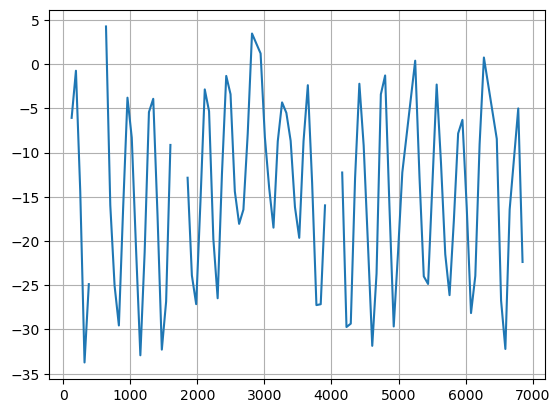

In [27]:
plt.plot(s_positions_bpms[mask_bpm], file.hor_turn_position[mask_bpm, -1])
plt.grid()

In [28]:
import apertls

In [29]:
line_thick = xt.Line.from_json('../injection_lines/injection_thick_approx_ap.json')

Loading line from dict:   0%|          | 0/7477 [00:00<?, ?it/s]

Done loading line from dict.           


In [30]:
ap_calc = apertls.ApertureCalculator(line)

In [31]:
x_ext = ap_calc.compute_x_extent()
y_ext = ap_calc.compute_y_extent()

In [33]:
mask_aperture =  [el.startswith('Limit') for el in tt.element_type]

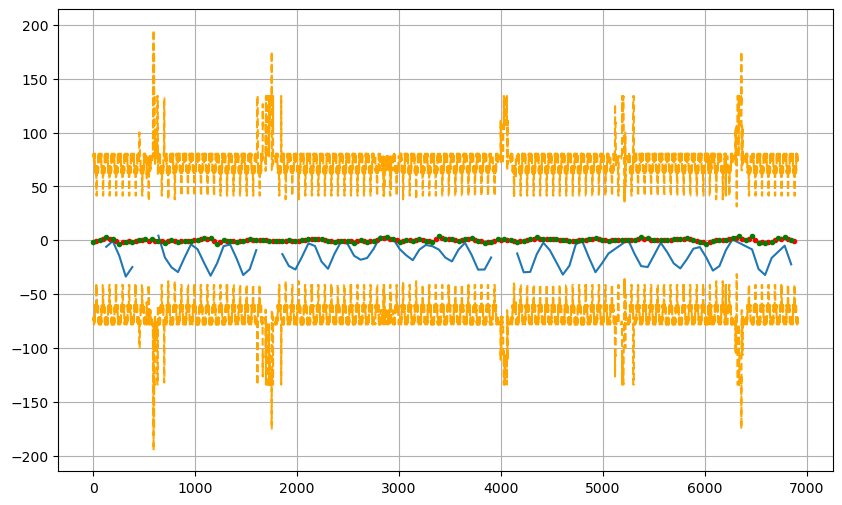

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(s_positions_bpms[mask_bpm], file.hor_turn_position[mask_bpm, -1])
ax.plot(tt.s[mask_aperture], x_ext[:, 0]*1e3, '--', color='orange', label='Aperture X max')
ax.plot(tt.s[mask_aperture], x_ext[:, 1]*1e3, '--', color='orange', label='Aperture X min')

ax.plot(tw_ref.rows['qd.*'].s, tw_ref.rows['qd.*'].x*1e3, 'r.', label='QD')
ax.plot(tw_ref.rows['qf.*'].s, tw_ref.rows['qf.*'].x*1e3, 'g.', label='QF')
ax.grid()


In [ ]:
tw